<a href="https://colab.research.google.com/github/shane-os/CE5021-Assignment3/blob/main/Assignment_3_student.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 3: Class Activation Map
In this assignment we will use the [Class Activation Mapping Technique](http://cnnlocalization.csail.mit.edu/Zhou_Learning_Deep_Features_CVPR_2016_paper.pdf) to demonstrate that object specific spatial information is available in pre-trained image classification networks.

## Introduction:
The final output convolution layers of a trained image classification network contain detailed semantic information about the input image. These feature maps, although low resolution (e.g. 7 x 7) also contain spatial information about the location of the primary object in the image. In the class activation mapping technique we wish to extract this spatial information pertaining to the identified class and overlay this activation on the input image as shown in the figure below.

![](https://github.com/tonyscan6003/etivities/blob/main/cam_img.JPG?raw=true)

* Try to understand the algorithm and plan out the steps required before starting to code.
* The Resnet 50 model has been imported and outputs the last convolution layer and the logits (output of classifier)
* You can display your final results on a 4 x 4 plot.
 * Skeleton code is provided along with a function to unormalise the dataloader images for display.
 * The activation map using a heat map color scheme can be overlaid on the images using matplotlib "alpha" which sets the transparancy of the image e.g. `plt.imshow(class_act_map,cmap=plt.cm.jet,alpha=0.4)`























## HouseKeeping
  Import Packages, set batch size and Size of Images input to network.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import time
import os
import numpy as np
import glob
import random
import torch
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, models
from torchvision import utils
from torchvision.transforms import ToTensor, v2, Pad, Grayscale
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
!pip install torchinfo
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 12.2 MB/s eta 0:00:00


In [3]:
# Global Variables
HW_trg =224

## Import Dataset

 For this notebook we will use the pytorch [ImageNett dataset](https://pytorch.org/vision/main/generated/torchvision.datasets.Imagenette.html) which contains a sub-set of the ImageNet test dataset with only 10 examples per class. This will be sufficient to demonstrate the Class Activation Mapping algorithm.

The transform is setup without data augmentation and with the required normalisation for the ResNet50 model.

In [4]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
imagenet_data = datasets.Imagenette('/root/INET',download=True,transform=transform)
data_loader = torch.utils.data.DataLoader(imagenet_data,
                                          batch_size=1,
                                          shuffle=True)

100%|██████████| 1.56G/1.56G [00:25<00:00, 62.0MB/s]


Extracting /root/INET/imagenette2.tgz to /root/INET


Plot a test image from the dataset. The image must be unnormalised and output in the correct form [H,W,C] for display by plt.imshow using `<unnormalise image function>`. (You can re-use this function later to unnormalise images that you will overlay the class activation maps onto.)

In [5]:

imagenette_dict={0:'Tench Fish',217:'English Springer',482:'Casette Player',
                491:'Chain Saw',497:'Church',566:'French Horn',
                 569:'Grabage Truck',571:'Gas Pump',574:'Golfball',
                 662:'Modem', 701:'Parachute',864:'Tow Truck', 867:'Trailer Truck'}
mean = [0.485, 0.456, 0.406]  # Example mean used for normalization
std = [0.229, 0.224, 0.225]   # Example std used for normalization

def unnormalize_image(image, mean, std):
    """
    Unnormalize a PyTorch image tensor.

    Args:
        image (torch.Tensor): The normalized image tensor of shape [C, H, W].
        mean (list or tuple): The mean used for normalization.
        std (list or tuple): The standard deviation used for normalization.

    Returns:
        torch.Tensor: The unnormalized image tensor.
    """
    # Remove the batch dimension
    image = image.squeeze(0)

    # Check if the image is in the shape [C, H, W]
    if image.dim() == 3:
        # Unnormalize the image
        for t, m, s in zip(image, mean, std):
            t.mul_(s).add_(m)
    else:
        raise ValueError("Expected image tensor of shape [C, H, W]")

    # Convert from [C, x, y] to [x, y, C]
    image = image.permute(1, 2, 0)

    return image

torch.Size([1, 3, 224, 224])
<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>
<class 'list'>


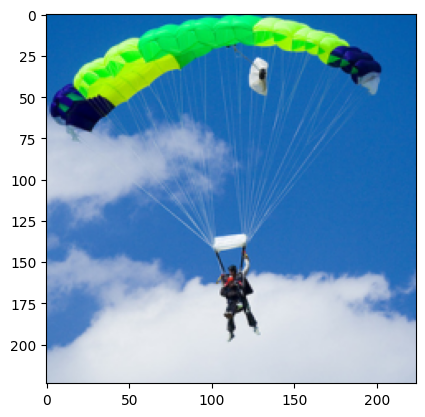

In [6]:
# Verity Dataloader & Image
dataiter = iter(data_loader)
z = next(dataiter)
print(np.shape(z[0]))

img=unnormalize_image(z[0],mean,std)
plt.imshow(img)
# Remove before submitting
print(type(dataiter))
print(type(next(dataiter)))
print(dataiter)




# Import Model

This assignment can be completed with CPU runtime as only inference from the model is required. The ResNet50 model is imported for this Assignment. As detailed in the paper a global average pooling layer conected to the classifier layer is required to work. The Resnet50 model satisfies this requirement (without needing modification & retraining)

In [7]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


ResNet50 Model is loaded & modified with [create_feature_extraction](https://pytorch.org/vision/stable/feature_extraction.html) to allow output of both logits and feature maps

In [8]:
# Load Model with weights
resnet50 = models.resnet50(pretrained=True)

# Obtain list of graph nodes
train_nodes, eval_nodes = get_graph_node_names(resnet50)
#print(train_nodes)

# Define Dictionary of output nodes
return_nodes={'layer4.2.conv3':'op_features','fc':'op_logits'}

# Create new model using the return nodes
model=create_feature_extractor(resnet50, return_nodes=return_nodes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 47.1MB/s]


In [9]:
# Plot Model Summary
from torchinfo import summary
summary(model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 1000]                 --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Module: 1-5                            --                        --
│    └─Module: 2-1                       --                        --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│ 

Test Passing data through model & verify outputs.

In [10]:
#pass data through model
out=model(z[0])
print([(k, v.shape) for k, v in out.items()])


[('op_features', torch.Size([1, 2048, 7, 7])), ('op_logits', torch.Size([1, 1000]))]


Obtain weights of classifier layer of model from state dictionary

In [11]:
sd = model.state_dict()
print(sd.keys())
print(np.shape((sd['fc.weight'])))

odict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.bn1.num_batches_tracked', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.bn2.num_batches_tracked', 'layer1.0.conv3.weight', 'layer1.0.bn3.weight', 'layer1.0.bn3.bias', 'layer1.0.bn3.running_mean', 'layer1.0.bn3.running_var', 'layer1.0.bn3.num_batches_tracked', 'layer1.0.downsample.0.weight', 'layer1.0.downsample.1.weight', 'layer1.0.downsample.1.bias', 'layer1.0.downsample.1.running_mean', 'layer1.0.downsample.1.running_var', 'layer1.0.downsample.1.num_batches_tracked', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.bn1.num_batches_tracked', 'layer1.1.conv2.we

# Class Activion Mapping
You can implement the class activation mapping algorithm in the code cell below.



/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


IndexError: index 1 is out of bounds for dimension 0 with size 1

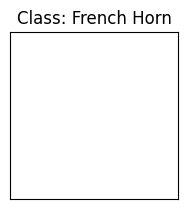

In [43]:
# To get the top 5 classes predicted by the model
from torch import topk

# Import cv2
import cv2

from logging import FileHandler

import matplotlib.pyplot as plt
import numpy as np

# Initialize Figure
fig = plt.figure(figsize=(10,10), frameon=False)


# Iterate over the dataiter to produce a few examples

# Ensure model is eval mode to disable batch normalisation during inference.
model.eval()

activations = []

# Take next batch of images:
dataiter = iter(data_loader)
images, labels = next(dataiter)


# def find_activation(layer):
def hook(model, input, output):
  # Append activation to activations
    activations.append(output)

target_layer = model.get_submodule('layer4.2.conv3')
# Connect to Hook
target_layer.register_forward_hook(hook)

def returnCAM(feature_conv, w_softmax, class_idx):
    _, nc, h, w = feature_conv.shape
    cam = w_softmax[class_idx].dot(feature_conv[0].reshape((nc, h * w)))
    cam = cam.reshape(h, w)
    cam -= np.min(cam)
    cam /= np.max(cam) if np.max(cam) != 0 else cam
    return np.uint8(255 * cam)

parameter_list = list(model.parameters())
w_softmax = np.squeeze(parameter_list[-2].detach().numpy())

for i in range(10):
  activations.clear()
  image = images[i].unsqueeze(0)
  original_image = unnormalize_image(images[i], mean, std).permute(1, 2, 0).numpy()
  original_image = (original_image - original_image.min()) / (original_image.max() - original_image.min())
  original_image = original_image.transpose(0, 2, 1)
  output = model(image)
  logits = output["op_logits"]
  probabilities = F.softmax(logits, dim=1).data.squeeze()
  class_idx = int(topk(probabilities, 1)[1].item())
  CAM = returnCAM(activations[0].detach().numpy(), w_softmax, class_idx)
  heatmap = cv2.applyColorMap(cv2.resize(CAM, (224, 224)), cv2.COLORMAP_JET)
  overlay = heatmap * 0.2 + (original_image * 255).astype(np.uint8)

  ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
  ax.title.set_text(f"Class: {imagenette_dict[class_idx]}")

# You may Leave a note here explaining your approach/results for the e-moderator.

Please clearly identify any code blocks you have used, suggestions your have tried or ideas obtained from other students. This information may also be posted as a final reflection post in the forum.

In this assignment I attempted to produce a series of Class Activation Maps (CAM) obtain from the classifications of the ResNet50 model. The dataset used in this assignment was Imagenette.

To produce the CAMs I tried to implement the following steps:

1. Locate the last CNN layer to obtain the weights required. This was identified as layer4.2.conv3.

2. Set up a hook function to capture the activations of the last CNN layer (layer4.2.conv3)

3. Class Predictions are gathered by passing forward through the model. The hook function in step 2. collects the activation.

4. The weights are applied to the feature map to create a CAM.

Final step: Overlay the original image with a heatmap.



I had some difficulty in completing this assignment. My initial issues were mainly in relation to handling the various formats of the images and rectifying the heatmaps and the original images. I think that I may have had some trouble understanding the process flow. Upon posting in the forum, Nikolaos Kollias suggested the following resource:

https://debuggercafe.com/basic-introduction-to-class-activation-maps-in-deep-learning-using-pytorch/

I followed his recommendation and it helped me to better understand the process flow. Some code used was obtained from this site and used in the assignment.

Unfortunately, my attempts to implement the GradCAM approach were unsuccessful. Despite numerous attempts, the usage of print and type statements and trial and error (e.g. format changes, examination and changes to the process flow) I was unable to resolve my coding issues which were in relation to image shapes and incompatible data types.

I included the import topk line of code as preparation in case I resolved the coding issues mentioned earlier.